# Descriptors
--------------------

In this notebook, we will take a look at the different structural descriptors and learn how to parametrize them and add filters.

## Common properties
-----------------------------

A structural descriptor $S(x)$ is a collection of $N$ individual empirical correlation functions $\{s_i(\vec{x})\}$ at the particle level, defined over a grid $\{x_j\}$ of $M$ features. These are stored in the `features` array as a matrix usually refered to as the "data set":

$$
\begin{pmatrix}
s_0(x_0) & s_0(x_1) & ... & s_0(x_M) \\
s_1(x_0) & s_1(x_1) & ... & s_1(x_M) \\ 
...      & ...      & ... & ... \\
s_N(x_0) & s_N(x_1) & ... & s_N(x_M)
\end{pmatrix}
$$

The `features` array is None by default and is computed only when the `compute()` method is called.

The correlations can be calculated between two arbitrary subsets of particles called "groups":
- group 0 is the main group, *i.e.* particles for which the correlations are being calculated ;
- group 1 is the secondary group, *i.e.* particles that are being considered when calculating the correlations ;
These groups are formed by adding filters on particles' properties (species, radius, position, etc.).

All descriptor classes inherit from the class `StructuralDescriptor`, thus having several common properties and attributes such as:
* `trajectory` : a descriptor is defined for a given `Trajectory` (see **notebook #1**) ;
* `dimension` : the spatial dimension of the descriptor. Indeed, some descriptors can only be computed for 2D or 3D trajectories ;
* `grid` : grid over which the structural features will be computed. For instance, the values of interparticle distances $r$ (*i.e.* bins) when using a radial descriptor ;
* `active_filters` : list of all active filters on the both groups of particles ;
* `features` : array of all the computed structural features for particles in the main group ($i.e.$ group 0) ;
* `size` : number of individual correlation functions $N$ ;
* `n_features` : the number of features $M$ for the descriptor (equivalent to the length of `grid` and `features.shape[1]`) ;
* `average` : average feature vector of the descriptor, *i.e.* $\sum_i s_i(\vec{x})$ ;

Let us consider a pratical example by creating a structural descriptor on a trajectory file:

In [1]:
from pysc import Trajectory
from pysc.descriptor import StructuralDescriptor

# Open a trajectory
traj = Trajectory('../data/kalj_N150.xyz', last=20)

# Create a descriptor
D = StructuralDescriptor(traj)

**N.B** Note that the class `StructuralDescriptor` does not perform any computation. This is only an example to show the common properties of the subclasses. Actual examples will be shown later in this notebook.

By default, all particles are included in groups 0 and 1. To restrict the computation of the descriptor to a given subset, we must apply a filter with the method `add_filter`. This is done by specifying the filter with a string of the form:

`"particle.<attribute> _operator_ <value>"`

or simply

`"<attribute> _operator_ <value>"`

for common attributes. Ex. `"species == 'A'"`, `"particle.radius < 0.5"`.

We must also specify the `group` over which this filter is applied.

The current input trajectory file is a binary mixture of particles labeled `"A"` and `"B"`. Let us restrict the computation of the structural features to B particles only:

In [2]:
# Add a filter on group 0
D.add_filter("species == 'B'", group=0)

# Active filters
print(D.active_filters)

[("particle.species == 'B'", 0)]


We can cumulate filters by adding them successively (as long as there are particles left in the specified group).

Now, let us make this a partial correlation by focusing the analysis on A particles:

In [3]:
D.add_filter("species == 'A'", group=1)
print(D.active_filters)

[("particle.species == 'B'", 0), ("particle.species == 'A'", 1)]


If the descriptor was describing radial correlations, this would be equivalent to computing the partial RDF between B and A particles, $g_{BA}(r)$. Filters can be removed with the methods `clear_filters` (clears all filters on the specified group) and `clear_all_filters` (clears all filters on both groups).

Now, in order to actually compute the structural features, the method `compute` must be called: `D.compute()`. This will set the `features` attribute. Let us move to more practical examples with actual descriptors.

## Radial descriptor
-------------------------

The class `RadialDescriptor` computes the radial correlations of a central particle with all its surrounding particles up to a given distance $R$. In practice, for a particle $i$, it computes a histogram for particles between $r$ and $r + \mathrm{d}r$ between the specified range:

In [4]:
from pysc.descriptor import RadialDescriptor

# radial descriptor between r=0 and r=2 with bin size dr=0.1
D_r = RadialDescriptor(traj, bounds=(0,2), dr=0.05)
# compute the features (also sets D_r.features)
X_r = D_r.compute()

# grid
print('grid = ', D_r.grid)
# radial histogram of particle #0
print('radial histogram of particle #0 :', X_r[0])

grid =  [0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125 1.175
 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575 1.625 1.675 1.725 1.775
 1.825 1.875 1.925 1.975]
radial histogram of particle #0 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 2 1 3 1 1 2 1 2 0 1 0 0 3 2 3 3 4 3
 4 2 3]


The average of the descriptor is the average over all histograms:

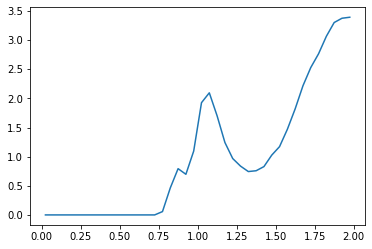

In [14]:
import matplotlib.pyplot as plt

plt.plot(D_r.grid, D_r.average)
plt.show()

Note that the bounds for the grid can be set automatically through the integer parameter `n_shells` (instead of specifying `bounds` manually). This will set the upper bound automatically by counting the number of coordination shells (default value is 3).

An example with a filter:

In [6]:
# A-A correlation
D_r_AA = RadialDescriptor(traj, bounds=(0,2), dr=0.05)
D_r_AA.add_filter("species == 'A'", 0)
D_r_AA.add_filter("species == 'A'", 1)
_ = D_r_AA.compute()

# A-B correlation
D_r_AB = RadialDescriptor(traj, bounds=(0,2), dr=0.05)
D_r_AB.add_filter("species == 'A'", 0)
D_r_AB.add_filter("species == 'B'", 1)
_ = D_r_AB.compute()

Let us normalize the distributions in order to get true $g(r)$:

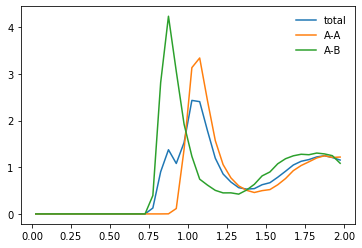

In [7]:
# /!\ normalization depends on the descriptor in this case
norm = D_r.normalize_gr
norm_AA = D_r_AA.normalize_gr
norm_AB = D_r_AB.normalize_gr

# plot
plt.plot(D_r.grid, norm(D_r.average), label='total')
plt.plot(D_r_AA.grid, norm_AA(D_r_AA.average), label='A-A')
plt.plot(D_r_AB.grid, norm_AB(D_r_AB.average), label='A-B')
plt.legend(frameon=False)
plt.show()

## Bond angle descriptor
-------------------------------

Similarly, the class `BondAngleDescriptor` counts the number of particles $(j,k)$ around a central particle $i$ such that the angle $\widehat{jik}$ is in the range $[\theta, \theta + \mathrm{d} \theta$]. Particles $j$ and $k$ must be in the first coordination shell of particle particle $i$.

This class inherits from a class `AngularStructuralDescriptor` (that inherits from `StructuralDescriptor`). It has several additional attributes:

* `nearest_neighbors_method` : must be `"FC"` (fixed cutoff) or `"SANN"` (solid angle based nearest-neighbors). See the documentation for more details ;
* `cutoffs` : cutoffs can be set manually when using `nearest_neighbors_method = "FC"`, or through the method `set_cutoff`. If not specified, they are computed automatically ;
* `neighbors` : list of nearest neighbors for each particle (in group 0). This is set once the method `nearest_neighbors` has been called ;

**N.B.** When using `"FC"` as nearest neighbors method and letting the code find the cutoffs automatically, it may happen that some cutoffs do not coincide with the actual cutoff $r_{cut}^{\alpha\beta}$ for a pair $(\alpha,\beta)$ of species. Indeed, if the shape of $g_{\alpha\beta(r)}$ is peculiar (*e.g.* very ordered systems or splitting of the first peak), the identification of the first coordination shell may be wrong. In this case, it is recommended to check the values of `cutoffs`.

In [8]:
from pysc.descriptor import BondAngleDescriptor

# bond angle descriptor with bin size dtheta=4 (in degrees)
D_ba = BondAngleDescriptor(traj, dtheta=4.0)
# compute the features
X_ba = D_ba.compute()

# cutoffs used to find neighbors
print('all pairs of species :', traj[0].pairs_of_species)
print('associated cutoffs :', D_ba.cutoffs)

# grid (from 0 to 180 deg.)
print('\ngrid = ', D_ba.grid)
# bond angles histogram of particle #0
print('radial histogram of particle #0 :', X_ba[0])
# neighbors of particles #0
print('neighbors of particle #0 :', D_ba.neighbors[0][0])

all pairs of species : [('A', 'A'), ('A', 'B'), ('B', 'A'), ('B', 'B')]
associated cutoffs : [1.4500000000000004, 1.2500000000000002, 1.2500000000000002, 1.9500000000000004]

grid =  [  2.   6.  10.  14.  18.  22.  26.  30.  34.  38.  42.  46.  50.  54.
  58.  62.  66.  70.  74.  78.  82.  86.  90.  94.  98. 102. 106. 110.
 114. 118. 122. 126. 130. 134. 138. 142. 146. 150. 154. 158. 162. 166.
 170. 174. 178.]
radial histogram of particle #0 : [ 0  0  0  0  0  0  0  0  0  0  2 12 10 16 16  0 12  6  4  4  0 10 10  4
  4  6 12 20  8  8  0  6  4  4  0  8  4  4  6  6  2  2  0  0  0]
neighbors of particle #0 : [ 16  37  39  56  63  69  75  89  90  96  98 101 113 123 144]


Average of the descriptor:

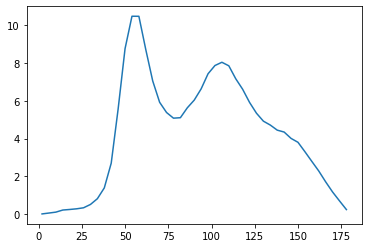

In [9]:
plt.plot(D_ba.grid, D_ba.average)
plt.show()

## Bond orientational parameters
------------------------------------------

The class `BondOrientationalDescriptor` computes bond orientational parameters $q_l$ (see [Steinhardt et al.](http://doi.org/10.1103/PhysRevB.28.784)) around particle $i$ surrounded by nearest neighbors $\{j\}$.

This class also inherits from the class `AngularStructuralDescriptor` (see the section **Bond angle descriptor** or the documentation for more details).

The minimal and maximal orders of $l$ must be specified through the parameters `lmin` and `lmax`. Otherwise, specific values of $l$ can be computed by using the list parameter `orders`:

In [10]:
from pysc.descriptor import BondOrientationalDescriptor

# BOP descriptor
D_bo = BondOrientationalDescriptor(traj, lmin=1, lmax=8)
print('range of values for l :', D_bo.grid)

# compute specific values instead
D_bo.orders = [4,6]
print('specific values of l :', D_bo.grid)

# change nearest neighbors method and compute
D_bo.nearest_neighbors_method = 'SANN'
X_bo = D_bo.compute()

range of values for l : [1 2 3 4 5 6 7 8]
specific values of l : [4 6]


Distributions of $q_4$ and $q_6$:

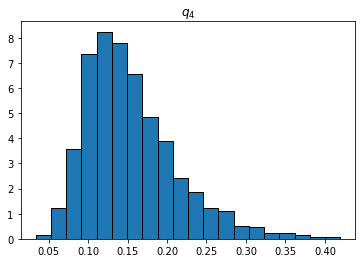

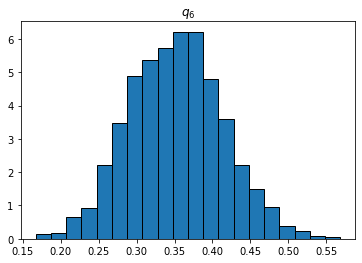

In [11]:
# q_4 (/!\ FIRST element of the grid)
plt.figure(1)
plt.hist(X_bo[:,0], ec='k', bins=20, density=True)
plt.title(r'$q_4$')
plt.show()

# q_6 (/!\ SECOND element of the grid)
plt.figure(1)
plt.hist(X_bo[:,1], ec='k', bins=20, density=True)
plt.title(r'$q_6$')
plt.show()

## Lechner-Dellago bond orientational parameters

The class `LechnerDellagoDescriptor` computes a variant $\bar{q}_l$ (as introduced by [Lechner & Dellago](http://doi.org/10.1063/1.2977970)) of the previously mentioned bond orientational parameters, $q_l$. This class inherits from `BondOrientationalDescriptor` and thus has the same parameters and attributes.

Note that this descriptor is more computationally expensive than its parent class.

In [12]:
from pysc.descriptor import LechnerDellagoDescriptor

# Lechner-Dellago descriptor
D_ld = LechnerDellagoDescriptor(traj, orders=[4,6])
# compute specific of values of l
print('grid of l :', D_ld.grid)

# change nearest neighbors method and compute
D_ld.nearest_neighbors_method = 'SANN'
X_ld = D_ld.compute()

grid of l : [4 6]


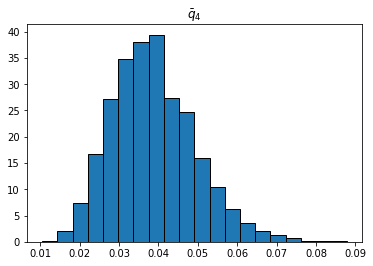

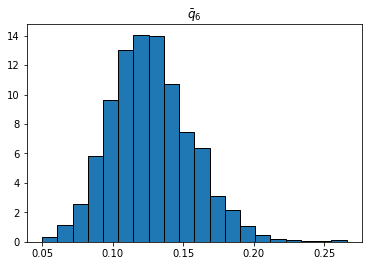

In [13]:
# q_4 (/!\ FIRST element of the grid)
plt.figure(1)
plt.hist(X_ld[:,0], ec='k', bins=20, density=True)
plt.title(r'$\bar{q}_4$')
plt.show()

# q_6 (/!\ SECOND element of the grid)
plt.figure(1)
plt.hist(X_ld[:,1], ec='k', bins=20, density=True)
plt.title(r'$\bar{q}_6$')
plt.show()